In [2]:
import pickle

from utils.corpus import RawSentence

with open("output/annotated_translated_tokenized_corpus_by_book.pkl", "rb") as file:
    corpus: dict[str, list[RawSentence]] = pickle.load(file)

combined_words = [word for _, sentences in corpus.items() for sentence in sentences for word in sentence["words"]]
print(f"Total tokens: {len(combined_words)}")
print(f"Total types: {len(set(combined_words))}")
print()

for book, sentences in corpus.items():
    print(f"Book: {book}")

    flattened_words = [word for sentence in sentences for word in sentence["words"]]
    print(f"Tokens: {len(flattened_words)}")
    print(f"Types: {len(set(flattened_words))}")
    print()


Total tokens: 1142993
Total types: 32717

Book: アイヌ語鵡川方言日本語‐アイヌ語辞典
Tokens: 54828
Types: 5239

Book: アイヌ語アーカイブ
Tokens: 505373
Types: 11361

Book: アイヌタイムズ
Tokens: 127685
Types: 8815

Book: 平取町アイヌ口承文芸
Tokens: 125787
Types: 6709

Book: アイヌ語アーカイブ音声資料
Tokens: 30357
Types: 2804

Book: AA研アイヌ語資料
Tokens: 88654
Types: 5197

Book: 浅井タケ昔話全集I,II
Tokens: 51195
Types: 3782

Book: 石狩川のアイヌ語（中級）
Tokens: 1175
Types: 418

Book: アイヌ語會話字典
Tokens: 11946
Types: 2148

Book: アイヌ語口承文芸コーパス
Tokens: 63453
Types: 3129

Book: 石狩川のアイヌ語（初級）
Tokens: 858
Types: 342

Book: 十勝のアイヌ語（初級）
Tokens: 616
Types: 250

Book: アイヌ語ラジオ講座テキスト
Tokens: 10316
Types: 1515

Book: アイヌ民族文化センター研究紀要
Tokens: 14877
Types: 1527

Book: アイヌ語音声資料
Tokens: 1416
Types: 555

Book: 十勝のアイヌ語（中級）
Tokens: 1235
Types: 387

Book: 沙流のアイヌ語（初級）
Tokens: 505
Types: 219

Book: カラフトのアイヌ語（中級）
Tokens: 1714
Types: 563

Book: 美幌のアイヌ語（初級）
Tokens: 1599
Types: 356

Book: 鍋沢元蔵筆録ノート
Tokens: 14444
Types: 2155

Book: アコㇿイタㇰ
Tokens: 1600
Types: 343

Book: 千徳太郎治のピウスツキ宛書簡
Tokens: 18

In [3]:
from collections import Counter

word_counts = Counter(combined_words)

with open("output/ainu_words_all.tsv", "w") as f:
    for word, count in word_counts.most_common():
        f.write(f"{word}\t{count}\n")

In [21]:
# TF-IDF
from typing import cast
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import json

def compute_tf_idf(corpus: dict[str, list[RawSentence]]):
    documents = {
        doc_id: "∥".join(word for sentence in sentences for word in sentence["words"])
        for doc_id, sentences in corpus.items()
    }

    vectorizer = TfidfVectorizer(
        tokenizer=lambda x: x.split("∥"), preprocessor=None
    )
    tfidf_matrix = cast(sparse.csr_matrix, vectorizer.fit_transform(documents.values()))
    feature_names = vectorizer.get_feature_names_out()

    tf_idf_scores = {}
    for doc_idx, doc_id in enumerate(documents.keys()):
        # Extract the non-zero elements for the document
        row = tfidf_matrix.getrow(doc_idx)  # Ensure we work with a sparse row
        non_zero_indices = row.indices
        tf_idf_scores[doc_id] = {
            feature_names[idx]: row[0, idx] for idx in non_zero_indices
        }

    return tf_idf_scores


# Example usage
tf_idf_scores = compute_tf_idf(corpus)


with open("output/tf_idf_scores3.json", "w") as f:
    json.dump(tf_idf_scores, f, ensure_ascii=False, indent=4)

/home/mkpoli/projects/Ainu/ainu-corpora-process/.venv/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


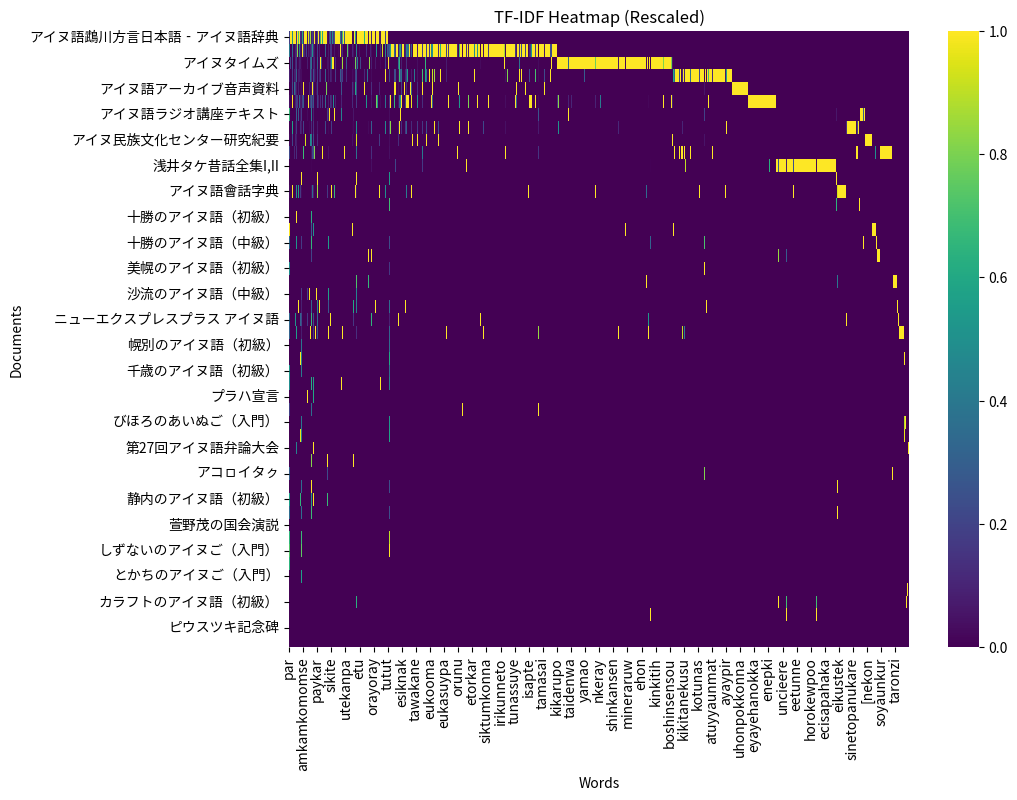

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.font_manager import FontProperties, fontManager
from sklearn.preprocessing import MinMaxScaler

font_path = "../fonts/NotoSansCJK-Regular.ttc"
fontManager.addfont(font_path)
font_prop = FontProperties(fname=font_path)

plt.rcParams["font.family"] = ["Noto Sans CJK JP"]

def visualize_tfidf_heatmap(tf_idf_scores):
    # Convert to DataFrame
    tfidf_df = pd.DataFrame.from_dict(tf_idf_scores, orient="index").fillna(0)

    # Rescale values between 0 and 1
    scaler = MinMaxScaler()
    tfidf_rescaled = pd.DataFrame(
        scaler.fit_transform(tfidf_df), index=tfidf_df.index, columns=tfidf_df.columns
    )

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(tfidf_rescaled, cmap="viridis", annot=False, cbar=True)
    plt.title("TF-IDF Heatmap (Rescaled)")
    plt.xlabel("Words")
    plt.ylabel("Documents")
    plt.show()


# Example usage
visualize_tfidf_heatmap(tf_idf_scores)

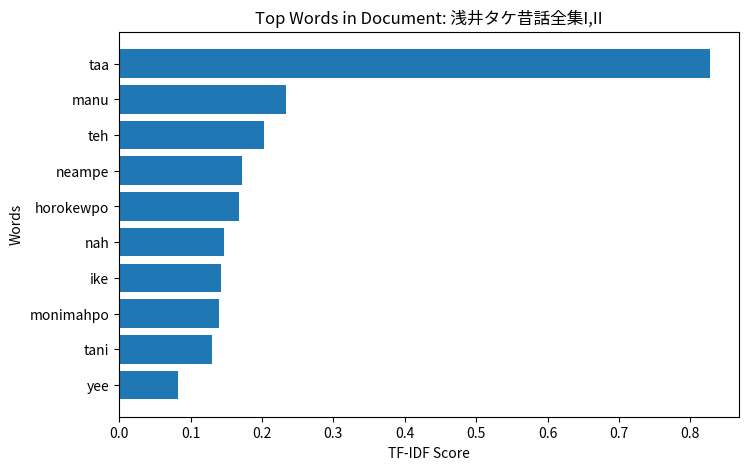

In [37]:
def visualize_tfidf_barchart(tf_idf_scores, doc_id):
    # Get the top words by TF-IDF score
    top_words = sorted(tf_idf_scores[doc_id].items(), key=lambda x: x[1], reverse=True)[
        :10
    ]
    words, scores = zip(*top_words)

    # Plot bar chart
    plt.figure(figsize=(8, 5))
    plt.barh(words, scores)
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.title(f"Top Words in Document: {doc_id}")
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Words")
    plt.show()


# Example usage
# visualize_tfidf_barchart(tf_idf_scores, doc_id="萱野茂の国会演説")
# visualize_tfidf_barchart(tf_idf_scores, doc_id="アイヌ語ラジオ講座テキスト")
# visualize_tfidf_barchart(tf_idf_scores, doc_id="アイヌタイムズ")
visualize_tfidf_barchart(tf_idf_scores, doc_id="浅井タケ昔話全集I,II")

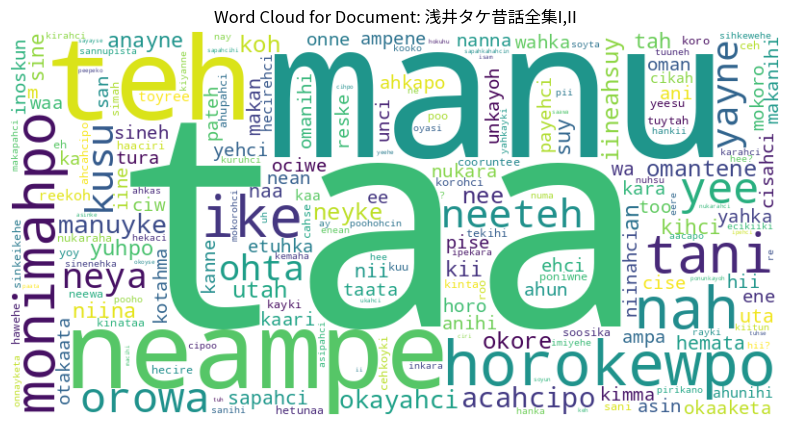

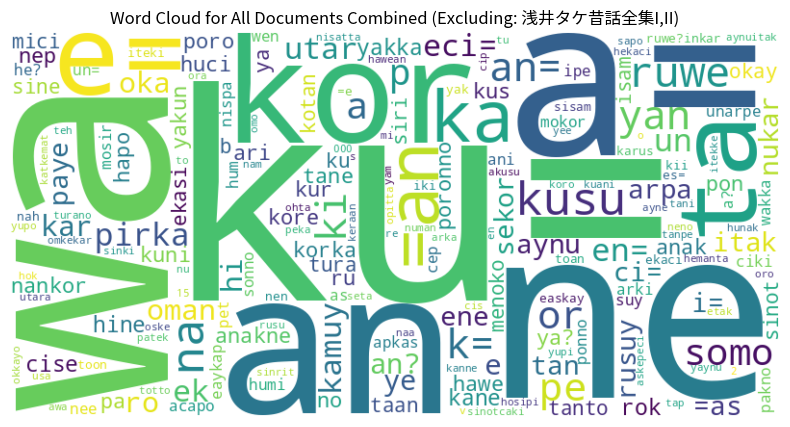

In [39]:
from wordcloud import WordCloud


def visualize_tfidf_wordcloud(tf_idf_scores, doc_id):
    # Generate word cloud data
    wordcloud = WordCloud(
        width=800, height=400, background_color="white"
    ).generate_from_frequencies(tf_idf_scores[doc_id])

    # Display word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Document: {doc_id}")
    plt.show()


# Example usage
visualize_tfidf_wordcloud(tf_idf_scores, doc_id="浅井タケ昔話全集I,II")

def visualize_tfidf_wordcloud_all_docs_combined_except(tf_idf_scores, except_doc_id: str): 
    combined_scores = {}
    for doc_id, scores in tf_idf_scores.items():
        if doc_id == except_doc_id:
            continue
        for word, score in scores.items():
            combined_scores[word] = combined_scores.get(word, 0) + score

    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, height=400, background_color="white"
    ).generate_from_frequencies(combined_scores)

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for All Documents Combined (Excluding: {except_doc_id})")
    plt.show()

# Example usage
visualize_tfidf_wordcloud_all_docs_combined_except(
    tf_idf_scores, except_doc_id="浅井タケ昔話全集I,II"
)


# visualize_tfidf_wordcloud(tf_idf_scores, doc_id="浅井タケ昔話全集I,II")

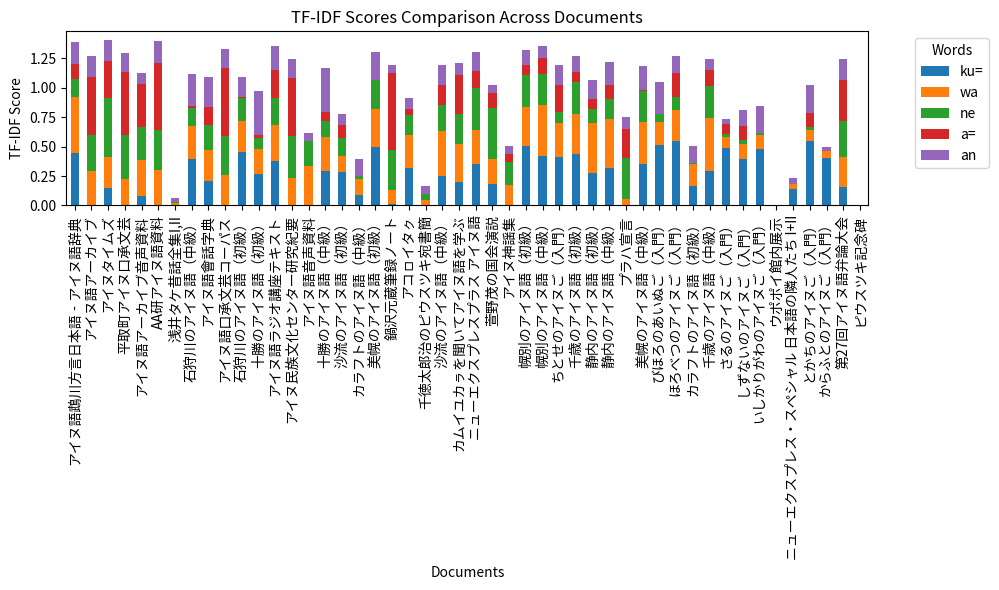

In [38]:
def visualize_tfidf_comparison(tf_idf_scores, top_n=5):
    # Aggregate top words across all documents
    all_words = {word for scores in tf_idf_scores.values() for word in scores}
    word_totals = {
        word: sum(scores.get(word, 0) for scores in tf_idf_scores.values())
        for word in all_words
    }
    top_words = sorted(word_totals.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Prepare data
    words, _ = zip(*top_words)
    comparison_df = pd.DataFrame(
        {
            doc_id: [tf_idf_scores[doc_id].get(word, 0) for word in words]
            for doc_id in tf_idf_scores.keys()
        },
        index=words,
    )

    # Plot stacked bar chart
    comparison_df.T.plot(kind="bar", stacked=True, figsize=(10, 6))
    plt.title("TF-IDF Scores Comparison Across Documents")
    plt.xlabel("Documents")
    plt.ylabel("TF-IDF Score")
    plt.legend(title="Words", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# Example usage
visualize_tfidf_comparison(tf_idf_scores)